In [ ]:
!pip install catboost
!pip install -q h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 MB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import datasets
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import catboost as cat
import h2o
from h2o.automl import H2OAutoML

In [ ]:
path = '/content/drive/MyDrive/datasets/playground-series-s3e10/'
df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
result = pd.read_csv(path + 'sample_submission.csv')

In [ ]:
df_train.head()

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0
4,4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0


In [ ]:
df_train.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

In [ ]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [ ]:
summary(df_train)

data shape: (117564, 9)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
Mean_Integrated,float64,0,0.0,11065,6.054688,189.367188,133.171875,87.093750,112.640625
SD,float64,0,0.0,49262,24.783273,93.602933,59.716081,36.257973,39.818393
EK,float64,0,0.0,37132,-1.730782,7.879628,0.043133,0.435469,0.379639
Skewness,float64,0,0.0,41366,-1.791886,65.385974,-0.703383,2.266057,0.922306
Mean_DMSNR_Curve,float64,0,0.0,12474,0.213211,217.371238,54.917224,3.417224,2.730769
SD_DMSNR_Curve,float64,0,0.0,48050,7.370432,109.890785,70.084438,21.865069,15.689690
EK_DMSNR_Curve,float64,0,0.0,42870,-2.597872,34.539844,0.749798,7.039330,8.193471
Skewness_DMSNR_Curve,float64,0,0.0,50648,-1.976976,1191.000837,-0.649512,52.686251,85.649785
Class,int64,0,0.0,2,0.000000,1.000000,0.000000,0.000000,0.000000


In [ ]:
num_columns = list(df_train.select_dtypes(include=['int','float']).columns)
cat_columns = list(df_train.select_dtypes(include=['object','bool','category']).columns)

print("Number of numerical columns:", len(num_columns))
print("Number of categorical columns:", len(cat_columns))
print("Total number of columns in the feature dataframe:", df_train.shape[1])

Number of numerical columns: 9
Number of categorical columns: 0
Total number of columns in the feature dataframe: 9


In [ ]:
scaler = StandardScaler()
df_train[num_columns] = scaler.fit_transform(df_train[num_columns])

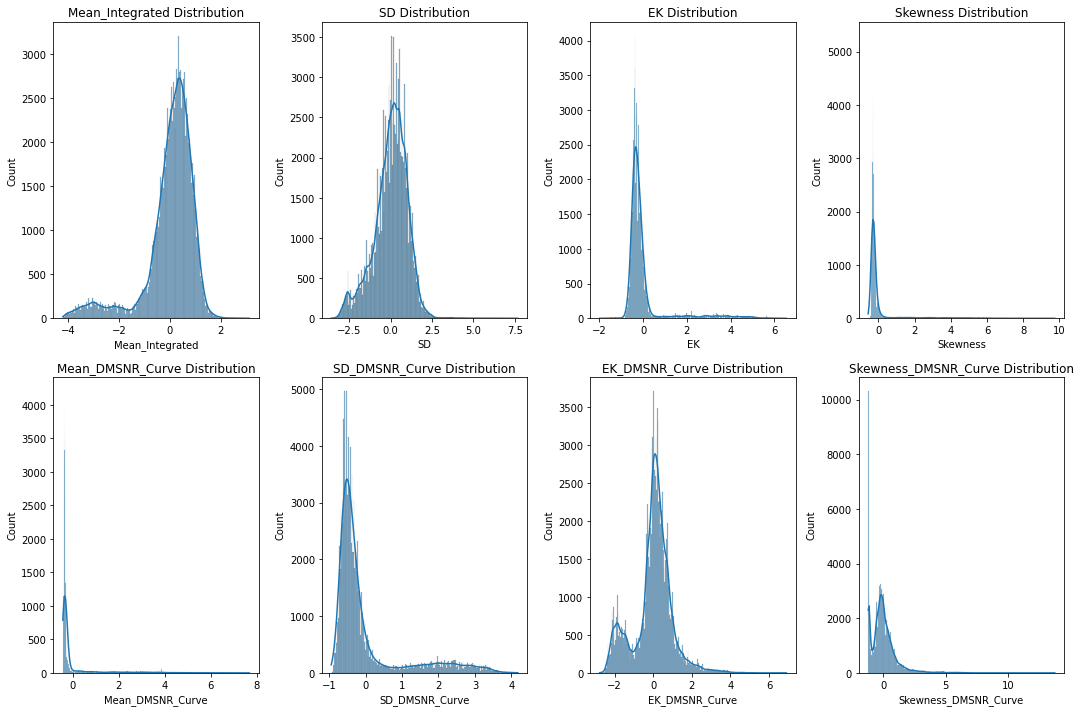

In [ ]:
plt.figure(figsize=(15,10))
for id,column in enumerate(num_columns[:-1]):
    plt.subplot(2,4,id+1)
    sns.histplot(x=column,data=df_train, kde=True, palette="Set1")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

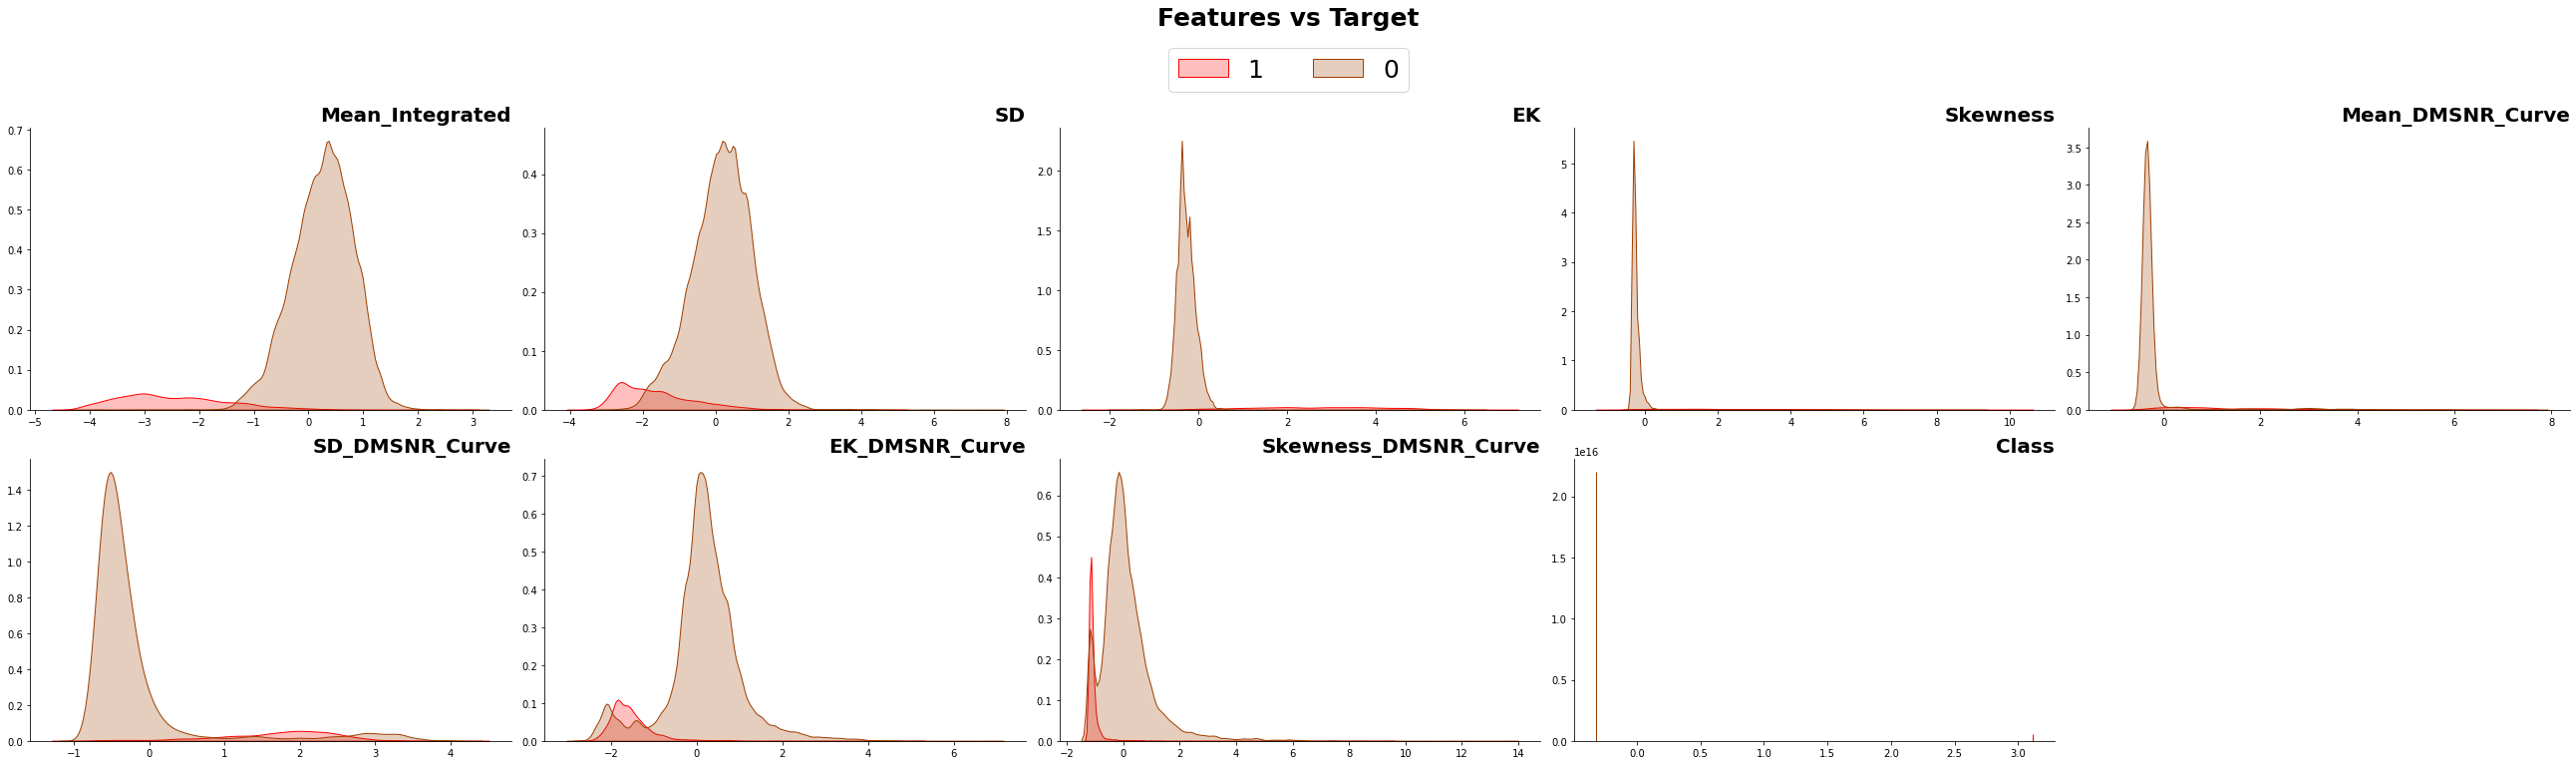

In [ ]:
figsize = (6*6, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(num_columns):
    ax = plt.subplot(4, 5, idx + 1)
    sns.kdeplot(
        data=df_train, hue='Class', fill=True,
        x=col, palette=['#9E3F00', 'red'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()
plt.show()

In [ ]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('Class')
target_col = 'Class'

In [ ]:
h2o.init() 

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpoe_hj7sj
  JVM stdout: /tmp/tmpoe_hj7sj/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpoe_hj7sj/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unknownUser_fqyus3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
train_h2o = h2o.H2OFrame(df_train)
train_h2o[target_col] = train_h2o[target_col].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
aml = H2OAutoML(max_models=15, project_name='classification', balance_classes=True, seed=1)
aml.train(x=feature_cols, y=target_col, training_frame = train_h2o)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),8/15
# GBM base models (used / total),4/6
# XGBoost base models (used / total),3/5
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),0/1
# DRF base models (used / total),0/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [ ]:
aml.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20230308_102553,0.995791,0.0313522,0.978412,0.0332995,0.0855807,0.00732405
StackedEnsemble_BestOfFamily_1_AutoML_1_20230308_102553,0.995715,0.0315505,0.977751,0.0333451,0.0856542,0.00733665
XGBoost_grid_1_AutoML_1_20230308_102553_model_1,0.995616,0.0321434,0.97827,0.0341832,0.0864391,0.00747172
XGBoost_grid_1_AutoML_1_20230308_102553_model_2,0.995343,0.033552,0.976871,0.0361866,0.0880905,0.00775994
GBM_2_AutoML_1_20230308_102553,0.995235,0.0340191,0.973484,0.0346532,0.0876582,0.00768397
GBM_1_AutoML_1_20230308_102553,0.995192,0.0340628,0.976911,0.0352607,0.0873222,0.00762517
GBM_3_AutoML_1_20230308_102553,0.99513,0.0352231,0.972462,0.0324331,0.0885923,0.00784859
XGBoost_3_AutoML_1_20230308_102553,0.994872,0.0402213,0.976995,0.0342374,0.0958275,0.00918291
GBM_4_AutoML_1_20230308_102553,0.994813,0.0378866,0.975889,0.0379628,0.0901276,0.00812299
DeepLearning_1_AutoML_1_20230308_102553,0.994811,0.0379049,0.972507,0.0365967,0.0903443,0.00816209


In [ ]:
model = aml.leader

In [ ]:
test_h2o = h2o.H2OFrame(df_test[feature_cols])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
y_pred = h2o.as_list(model.predict(test_h2o), use_pandas=True)['p1'].tolist()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [ ]:
result['Class'] = y_pred
result.to_csv('submission.csv', index=False)
result

,id,Class
0,117564,0.000167
1,117565,0.003664
2,117566,0.000209
3,117567,0.161676
4,117568,0.002760
...,...,...
78372,195936,0.000287
78373,195937,0.000183
78374,195938,0.000356
78375,195939,0.111908
